# <font color='Cyan'> Modèle à 1 neurone avec reconaissance d'image

In [398]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.metrics import accuracy_score

#fonction pour avoir un backfround de figure noir
plt.style.use('dark_background')
plt.rcParams.update({
    "figure.facecolor":  (0.12 , 0.12, 0.12, 1),
    "axes.facecolor": (0.12 , 0.12, 0.12, 1),
})

# Fonction pour charger les datas depuis les fichiers dans le répertoire

In [263]:
def load_data():
    train_dataset = h5py.File('trainset.hdf5', "r")
    X_train = np.array(train_dataset["X_train"][:])
    Y_train = np.array(train_dataset["Y_train"][:])

    test_dataset = h5py.File('testset.hdf5', "r")
    X_test = np.array(test_dataset["X_test"][:]) 
    Y_test = np.array(test_dataset["Y_test"][:])
    
    return X_train, Y_train, X_test, Y_test

# 1. Dataset

In [266]:
X_train, Y_train, X_test, Y_test = load_data()
print(X_train.shape)
print(Y_train.shape)
print(np.unique(Y_train, return_counts=True))

(1000, 64, 64)
(1000, 1)
(array([0., 1.]), array([500, 500], dtype=int64))


In [268]:
print(X_test.shape)
print(Y_test.shape)
print(np.unique(Y_test, return_counts=True))

(200, 64, 64)
(200, 1)
(array([0., 1.]), array([100, 100], dtype=int64))


### affichage des données (10 images seulement).

<function matplotlib.pyplot.show(close=None, block=None)>

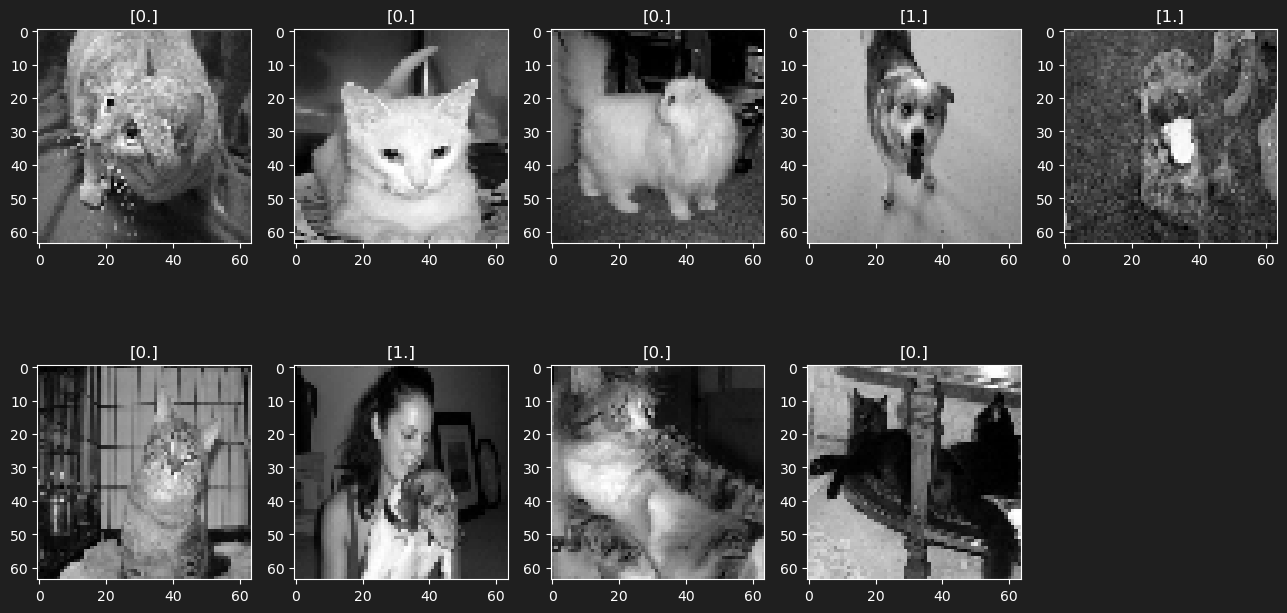

In [270]:
plt.figure(figsize=(16,8))
for i in range(1, 10):
    plt.subplot(2,5,i) #Arguments : nombre d'image  par ligne; nombre d'image par colnne; l'index i qui parcours les images
    plt.imshow(X_train[i], cmap = 'gray')
    plt.title(Y_train[i])
    plt.tight_layout
plt.show

# 2. Entrainemment du Module

In [272]:
def Initialisation(X):
    W = np.random.randn(X.shape[1], 1)
    b = np.random.randn(1)
    return(W,b)

In [273]:
def model(X,W,b):
    Z = X.dot(W) + b
    #print(Z.min())
    A = 1/ (1 + np.exp(-Z))
    return A

In [274]:
def log_loss(A, y):
    epsilon = 1e-15
    return 1 / len(y) * np.sum(-y * np.log(A + epsilon) - (1 - y) * np.log(1 - A + epsilon))

# 3. Gradients et Descente de Gradients

In [276]:
def gradients(A, X, y):
    dW = 1/ len(y) * np.dot(X.T, A - y)
    db = 1/ len(y) * np.sum(A - y)
    return(dW, db)

In [277]:
def update(dW, db, W, b, learning_rate):
    W = W - learning_rate * dW
    b = b - learning_rate * db
    return(W, b)

In [311]:
def prediction(X, W, b):
    A = model(X, W, b)
    #print(A)
    return A >= 0.5

# 4. Création de notre neurone

In [321]:
from tqdm import tqdm #permet l'affichage d'une barre de progression pendant le calcul

In [363]:

def artificial_neuron(X_train, Y_train, X_test, Y_test, learning_rate = 0.1, n_iter = 100):
    # initialisation W, b
    W, b = Initialisation(X_train)

    train_loss = []
    train_acc = []
    test_loss = []
    test_acc = []

    for i in tqdm(range(n_iter)):
        A = model(X_train, W, b)

        if i %10 == 0: # on reduit le nombre de calcul à faire
            # Train
            train_loss.append(log_loss(A, Y_train))
            Y_pred = prediction(X_train, W, b)
            train_acc.append(accuracy_score(Y_train, Y_pred))

            # Test
            A_test = model(X_test, W, b)
            test_loss.append(log_loss(A_test, Y_test))
            Y_pred = prediction(X_test, W, b)
            test_acc.append(accuracy_score(Y_test, Y_pred))

        #algo de du gradient descent
        dW, db = gradients(A, X_train, Y_train)
        W, b = update(dW, db, W, b, learning_rate)


    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label='train loss')
    plt.plot(test_loss, label='test loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(train_acc, label='train acc')
    plt.plot(test_acc, label='test acc')
    plt.legend()
    plt.show()

    return (W, b)

### Il faut que l'on convertisse les dimensions de nos données pour les mettre de dim 3 :(1000, 64,64) à une dimension égale à 2.
### On va enfaite applatir les données pour que tous les pixels de chaques photos se retrouvent sur une même dimension.

In [291]:
X_train_reshape = X_train.reshape(X_train.shape[0], X_train.shape[1] * X_train.shape[2])
X_train_reshape = X_train_reshape / X_train.max() #permet de metrre le max de chaque pixel à 1. (0 à 255) -> (0 à 1). élimine l'overflow
# équivalent si on écrit un reshape de la façon ci-dessous :
# X_train_reshape = X_train.reshape(X_train.shape[0], -1) Redimensionne toutes les data restantes. (multiplication matricielle des data restantes)

X_test_reshape = X_test.reshape(X_test.shape[0], -1) / X_train.max()

print(X_train_reshape.shape)
print(X_test_reshape.shape)
print(X_train_reshape.max())
print(X_test_reshape.max())

(1000, 4096)
(200, 4096)
1.0
1.0


100%|██████████| 5000/5000 [01:11<00:00, 69.86it/s] 


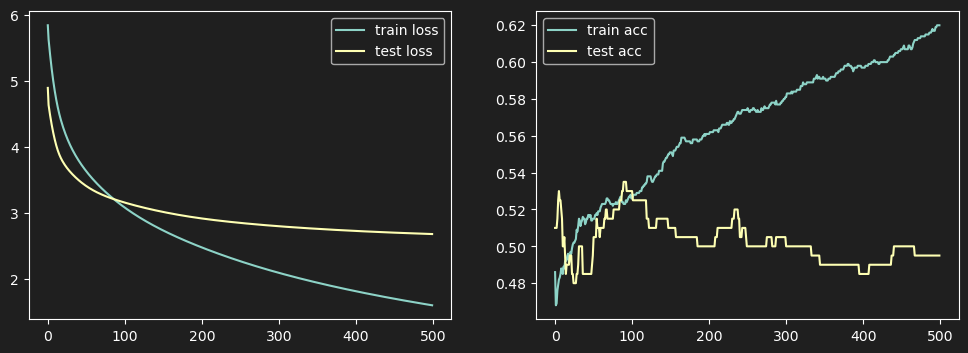

In [361]:
W, b = artificial_neuron(X_train_reshape, Y_train, X_test_reshape, Y_test, learning_rate = 0.01, n_iter = 5000)

### Notre modèle n'est clairement pas performant. Il est en over fitting et on voit qu'il n'arrive pas à s'améliorer malgré son entrainement.

## <font color='red'> Pour améliorer notre modèle, on peut augmenter le nombre de data (le nombre de photos). Ou bien réduire l'écart entre le nombre de photos et le nombre de variables. Cependant le mieux à faire reste d'ajouter des neurones pour creer un réseau de neurones. </font>

# 5. Normalisation des datas

### il faut que l'on donne la même dimension à nos donées x(i) car sinon le changement de la valeur de nos poids n'aura pas le même impact en fonction de si il est associé à x1 ou x2 par exemple. Pour cela on normalise nos données.

dimensions de X: (100, 2)
dimensions de y: (100, 1)


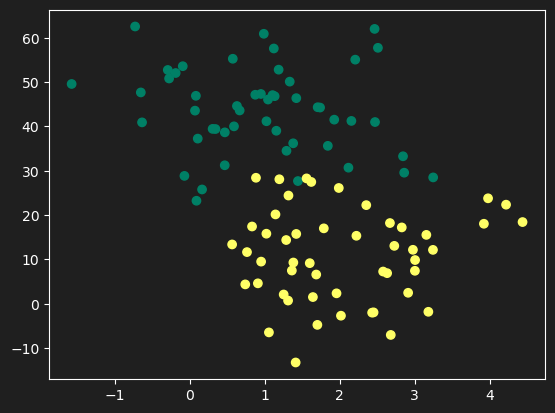

In [170]:

X, y = make_blobs(n_samples=100, n_features=2, centers=2, random_state=0)
y = y.reshape((y.shape[0], 1))
X[:, 1] = X[:, 1] * 10 #on multiplie les valeurs de x2 par 10 pour regarder l'influence du changement sur la fonction coût

print('dimensions de X:', X.shape)
print('dimensions de y:', y.shape)

plt.scatter(X[:,0], X[:, 1], c=y, cmap='summer')
plt.show()

In [92]:
lim = 10
h = 100
W1 = np.linspace(-lim, lim, h)
W2 = np.linspace(-lim, lim, h)

W11, W22 = np.meshgrid(W1, W2) # recopie de chaque valeur W11 dans W22
W11.shape
W_final = np.c_[W11.ravel(), W22.ravel()].T #on concataine W11 et W22 chacun comprésser puis on transpose le tout pour avoir une dimension (2, 100*100)
W_final.shape


(2, 10000)

In [172]:
b = 0
Z = X.dot(W_final) + b
A =1 / (1+ np.exp(-Z))

epsilon = 1e-15
L = 1 / len(y) * np.sum(-y * np.log(A + epsilon) - (1 - y) * np.log(1 - A + epsilon), axis=0).reshape(W11.shape)
L.shape

(100, 100)

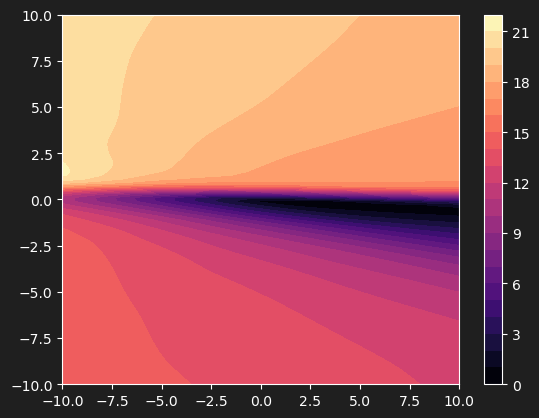

In [174]:
plt.contourf(W11, W22, L, 20, cmap='magma') #(axe x, axe y, valeurs de la colr barre, nombre de couches, type)
plt.colorbar()

### on peut donc voir que pour une valeur de W11 de -5 et W22 de -5, on a un coût d'environ 9 pour x1 et x2 avec le meme ordre de grandeur. 

### Cependant, si on multiplie x2 par 10, on a x2 qui est environ 10 fois plus grands  que x1 et on obtient un graphe compressé. C'est-à-dire qu'un changement de W22 de -5 -> 5 à une grande influence alors que pour un changement de W11 de -5 -> 5, le coût n'a presque pas changé.

## <font color='red'> Concrétement, Cela implique que l'algo de la descente de gradient va avoir du mal à converger vers un minimum. ou l'hyperparametre alpha va multiplier W1 et W2 mais comme ces derniers n'ont plus la même influence à cause du changement d'échelle sur les datas, on va osciller autour de la valeur minimale. </font>